## Setting up Environment

In [4]:
#Set up for Jupyter Notebook

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.models.keyedvectors as word2vec
import numpy as np
from torch import nn
import torch

train_data = pd.read_csv('cw2_train.csv')
dev_data = pd.read_csv('cw2_dev.csv')

word_vec_dim = 100
path = "glove/glove.6B.{}d.txt".format(word_vec_dim)
word_vectors = KeyedVectors.load_word2vec_format(datapath(path))

In [ ]:
train_data = train_dataset
dev_data = dev_dataset

print("Number of training samples: ", len(train_data))
print("Number of test samples: ", len(dev_data))

Number of training samples:  11498
Number of test samples:  3000


In [ ]:
oov_vec = np.random.rand(word_vec_dim)

def get_sent_word_vecs(word_vectors, sent_words):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Code for training neural model, evaluating and analysing it

---
The data is trained based on the 100 dimensions word embeddings from the GloVe file. 
The test_and_analyse() function returns a dataframe with relevant information for analysis of the correct and incorrect semantic similarity.

Sentence similarity is measured based on a significance threshold having default value of 5%, but can be customized. Significance threshold x% implies that if the difference between the predicted similarity and actual similarity is within x%, then the prediction is considered correct, otherwise incorrect.

In [ ]:
def train(model, data, optimizer):
    model.train()
    train_loss = 0
    for batch, sample in data.sample(frac=1).iterrows():
        s1,s2,target = sample['Sent1'], sample['Sent2'], torch.FloatTensor([sample['SimScore']]).to(device)

        s1_embeddings = get_sent_word_vecs(word_vectors, s1.split())
        s1_embeddings = s1_embeddings.reshape((s1_embeddings.shape[1], s1_embeddings.shape[0]))
        s2_embeddings = get_sent_word_vecs(word_vectors, s2.split())
        s2_embeddings = s2_embeddings.reshape((s2_embeddings.shape[1], s2_embeddings.shape[0]))
                                                      
        optimizer.zero_grad()
        
        s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)
        x=s1_vector.reshape(1,-1)
        y=s2_vector.reshape(1,-1)
        prediction = cos(x, y)

        loss = loss_criteria(prediction, target)
        train_loss += loss.detach()
        loss.backward()
        optimizer.step()

    avg_loss = train_loss / (batch+1)
    return avg_loss

def test(model, data):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        batch_count = 0
        for batch, sample in data.sample(frac=1).iterrows():
            batch_count += 1
            s1,s2,truth = sample['Sent1'], sample['Sent2'], \
                          torch.FloatTensor([sample['SimScore']]).to(device)                                          
        
            s1_embeddings = get_sent_word_vecs(word_vectors, s1.split())
            s1_embeddings = s1_embeddings.reshape((s1_embeddings.shape[1], s1_embeddings.shape[0]))
            s2_embeddings = get_sent_word_vecs(word_vectors, s2.split())
            s2_embeddings = s2_embeddings.reshape((s2_embeddings.shape[1], s2_embeddings.shape[0]))
            
            s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

            x=s1_vector.reshape(1,-1)
            y=s2_vector.reshape(1,-1)
            prediction = cos(x, y)
            test_loss += loss_criteria(prediction, truth)

    avg_loss = test_loss/batch_count
    print('MSE of the method on the dev set:', avg_loss.item())
    
    return avg_loss.item()

def test_and_analyse(model, data, significance_threshold=5):
    model.eval()
    test_loss = 0
    analysis = {}

    with torch.no_grad():
        batch_count = 0
        correct = 0
        for batch, sample in data.sample(frac=1).iterrows():
            batch_count += 1
            s1,s2,truth = sample['Sent1'], sample['Sent2'], \
                          torch.FloatTensor([sample['SimScore']]).to(device)                                          
        
            s1_embeddings = get_sent_word_vecs(word_vectors, s1.split())
            s2_embeddings = get_sent_word_vecs(word_vectors, s2.split())

            s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

            x=s1_vector.reshape(1,-1)
            y=s2_vector.reshape(1,-1)
            prediction = cos(x, y)
            test_loss += loss_criteria(prediction, truth)   
            significance = (truth.item()-prediction.item())/ (truth.item()+1e-10) * 100

            if significance > significance_threshold:
                if len(analysis)>0:
                    analysis['Sent1'] = analysis['Sent1'] + [s1]
                    analysis['Sent2'] = analysis['Sent2'] + [s2]
                    analysis['Prediction']= analysis['Prediction'] + [prediction.item()]
                    analysis['Truth']= analysis['Truth'] + [truth.item()]
                    analysis['Sent1 Embeddings']= analysis['Sent1 Embeddings'] + [s1_embeddings.shape[0]]
                    analysis['Sent2 Embeddings']= analysis['Sent2 Embeddings'] + [s2_embeddings.shape[0]]
                    analysis['Correct'] = analysis['Correct'] + ['False']
                else:
                    analysis['Sent1'] = [s1]
                    analysis['Sent2'] = [s2]
                    analysis['Prediction']= [prediction.item()]
                    analysis['Truth']= [truth.item()]
                    analysis['Sent1 Embeddings']= [s1_embeddings.shape[0]]
                    analysis['Sent2 Embeddings']= [s2_embeddings.shape[0]]
                    analysis['Correct'] = ['False']
            else:
              if len(analysis)>0:
                  analysis['Sent1'] = analysis['Sent1'] + [s1]
                  analysis['Sent2'] = analysis['Sent2'] + [s2]
                  analysis['Prediction']= analysis['Prediction'] + [prediction.item()]
                  analysis['Truth']= analysis['Truth'] + [truth.item()]
                  analysis['Sent1 Embeddings']= analysis['Sent1 Embeddings'] + [s1_embeddings.shape[0]]
                  analysis['Sent2 Embeddings']= analysis['Sent2 Embeddings'] + [s2_embeddings.shape[0]]
                  analysis['Correct'] = analysis['Correct'] + ['True']
              else:
                  analysis['Sent1'] = [s1]
                  analysis['Sent2'] = [s2]
                  analysis['Prediction']= [prediction.item()]
                  analysis['Truth']= [truth.item()]
                  analysis['Sent1 Embeddings']= [s1_embeddings.shape[0]]
                  analysis['Sent2 Embeddings']= [s2_embeddings.shape[0]]
                  analysis['Correct'] = ['True']
              correct+=1

    print("Number of correct predictions: ", correct)
    print("Number of incorrect predictions: ", len(dev_data)-correct)

    avg_loss = test_loss/batch_count
    print('Loss of the method on the dev set:', avg_loss.item())
    
    return avg_loss.item(), pd.DataFrame(analysis)

In [ ]:
EPOCHS = 25

## Base CNN Model Architecture:

---
1. 1D CNN later with input = dimension of embedding, output = customisable, kernel size = 1, activation = ReLU()
2. 1D Maxpool Layer
3. 2 fully connected layers
4. 1 activation function for dense layers: ReLU()

This simple CNN Architecture is tested with different number of epochs, learning rates and optimizers.
RMSprop and SGD optimizers have consistently provided lowerer MSE loss over multiple iterations of training the model.
Effect of epochs has varied - but 25, 30 epochs have lower MSE loss. Loss increases when the model is trained for 40 epochs.

Training with GPU reduces training time by half. Training with TPU is not as fast as training with GPU.

Learning rate = 0.001 gives lowest MSE, and larger learning rates increases loss by a lot. Maybe it's because we are training we small number of epochs. For Epochs = 25, learning rate larger than 0.01 does not yield an optimal model.

Experimenting with different output dimensions of the convolutional layer shows that output dimension = 64 gives lowest MSE.

Lowest MSE Loss = 0.07407581806182861 is when the model is trained with the following hyperparameters:
1. Epochs = 25
2. Optimizer = RMSprop
3. Learning Rate = 0.001
4. L2 Regularization = 0.0001

L2 regularization improves the loss over dropouts. Further below there are multiple models with dropout layers, they perform poorly.

After experimentation, the most important hyperparameter seems to be the optimizer and epoch. No other hyperparameter has as much impact.
In fact, the graphs and output below show that the MSE is around 0.1-0.2 when the output dimensions are changed.

The lowest MSE is in the range 0.070 - 0.078

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self, embedded_dimension, conv_out, window):
        super(BaseCNN, self).__init__()
        self.vector_dim = embedded_dimension
        self.window = window
        self.out = conv_out
        self.activation = nn.ReLU()
        self.convolution = self.convolutional_layer()
        self.fc1 = nn.Linear(in_features=self.out, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=self.vector_dim)

    def convolutional_layer(self):
        return nn.Sequential(
            nn.Conv1d(in_channels=self.vector_dim, out_channels=self.out, kernel_size=self.window),
            nn.ReLU()
        )   

    def build_CNN(self, input_data):
        conv_output = self.convolution(input_data)
        kernel = conv_output.shape[2]
        maxpool = nn.MaxPool1d(kernel_size=kernel) 
        return maxpool(conv_output).squeeze()

    def forward(self, sent1, sent2):
        sent1 = torch.FloatTensor(sent1).to(device).unsqueeze(0)
        sent2 = torch.FloatTensor(sent2).to(device).unsqueeze(0)

        sent1 = self.build_CNN(sent1)
        sent1 = self.activation(self.fc1(sent1))
        sent1 = self.activation(self.fc2(sent1))
        sent2 = self.build_CNN(sent2)
        sent2 = self.activation(self.fc1(sent2))
        sent2 = self.activation(self.fc2(sent2))

        return sent1, sent2

In [ ]:
model = BaseCNN(word_vec_dim, 64, 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
optimizer.zero_grad()
validation_loss = []
for epoch in tqdm(range(1, 21)):
    train_loss = train(model, train_data, optimizer)
print("Avg MSE Loss on Dev Data = ", test(model, dev_data))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)



MSE of the method on the dev set: 0.07381385564804077
Avg MSE Loss on Dev Data =  0.07381385564804077


In [ ]:
model = BaseCNN(word_vec_dim, 64, 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
training_loss = []
validation_loss = []
for epoch in tqdm(range(1, EPOCHS + 1)):
    print("Epoch: ", epoch)
    train_loss = train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
print("Avg MSE Loss on Dev Data = ", np.mean(np.array(validation_loss)))

Epoch:  1
MSE of the method on the dev set: 0.09334756433963776
Epoch:  2
MSE of the method on the dev set: 0.08497055619955063
Epoch:  3
MSE of the method on the dev set: 0.08537787944078445
Epoch:  4
MSE of the method on the dev set: 0.07911491394042969
Epoch:  5
MSE of the method on the dev set: 0.074064701795578
Epoch:  6
MSE of the method on the dev set: 0.07650457322597504
Epoch:  7
MSE of the method on the dev set: 0.07423301786184311
Epoch:  8
MSE of the method on the dev set: 0.07495955377817154
Epoch:  9
MSE of the method on the dev set: 0.07240498065948486
Epoch:  10
MSE of the method on the dev set: 0.0740690529346466
Epoch:  11
MSE of the method on the dev set: 0.07369080185890198
Epoch:  12
MSE of the method on the dev set: 0.07271203398704529
Epoch:  13
MSE of the method on the dev set: 0.07368828356266022
Epoch:  14
MSE of the method on the dev set: 0.07183430343866348
Epoch:  15
MSE of the method on the dev set: 0.07417682558298111
Epoch:  16
MSE of the method on the d

Minimum regularisation is required as the training data over fits the test data for a very short period of time in between epochs 20 and 30. That is why training with 20 epochs gives best results at low weight decay values.



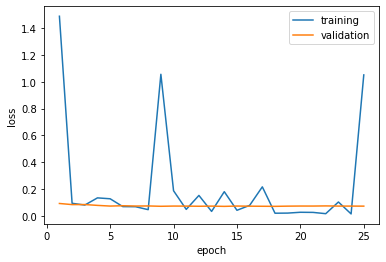

In [ ]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1, EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Analysing Effect of Epochs

In [ ]:
model = BaseCNN(word_vec_dim, 64, 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

epoch_list = [15, 20, 25, 30, 40]
validation_mse = []
for epochs in tqdm(epoch_list):
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = train(model, train_data, optimizer)
        training_loss.append(train_loss)

    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


MSE of the method on the dev set: 0.0747179165482521



MSE of the method on the dev set: 0.07578461617231369



MSE of the method on the dev set: 0.07448425889015198



MSE of the method on the dev set: 0.0742981880903244



MSE of the method on the dev set: 0.07596622407436371



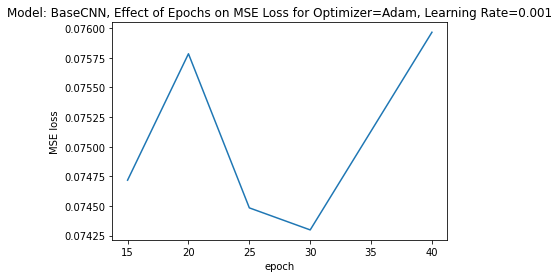

In [ ]:
plt.plot(epoch_list, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title("Model: BaseCNN, Effect of Epochs on MSE Loss for Optimizer=Adam, Learning Rate=0.001")
plt.show()

## Analysing Learning Rates

In [ ]:
model = BaseCNN(word_vec_dim, 64, 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
validation_mse = []

for lr in tqdm(learning_rates):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)



MSE of the method on the dev set: 0.08037301898002625



MSE of the method on the dev set: 0.07849214226007462



MSE of the method on the dev set: 0.07872000336647034



MSE of the method on the dev set: 0.07872336357831955



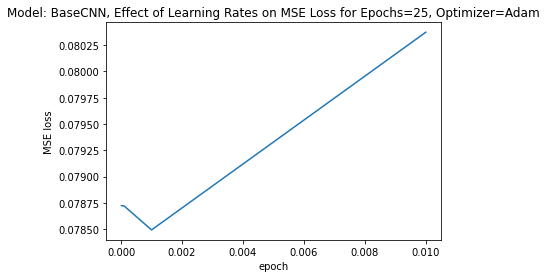

In [ ]:
plt.plot(learning_rates, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title('Model: BaseCNN, Effect of Learning Rates on MSE Loss for Epochs=25, Optimizer=Adam')
plt.show()

## Experimenting with Output Dimensions of Convolutional Layer

Output dimensions of the convolutional layer have an effect on the loss. 64 and 256 are the best values for the output dimensions. We have used 64 to increase computational efficiency.

In [ ]:
out_dimensions = [32, 64, 100, 256, 500, 800]
learning_rate = 0.0001
cos = nn.CosineSimilarity()
validation_mse = []

for out in tqdm(out_dimensions):
    model = BaseCNN(word_vec_dim, out, 1)
    model.to(device)
    loss_criteria = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


MSE of the method on the dev set: 0.22281436622142792



MSE of the method on the dev set: 0.1924666315317154



MSE of the method on the dev set: 0.22007374465465546



MSE of the method on the dev set: 0.20350198447704315



MSE of the method on the dev set: 0.22449997067451477



MSE of the method on the dev set: 0.21411588788032532



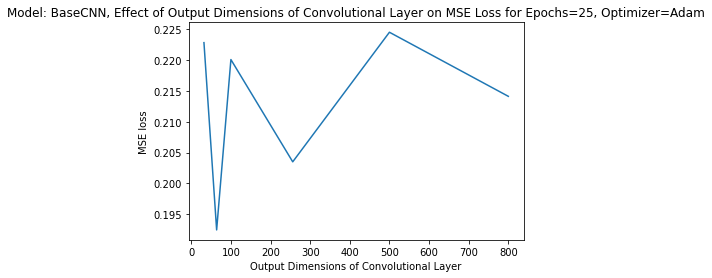

In [ ]:
plt.plot(out_dimensions, validation_mse)
plt.xlabel('Output Dimensions of Convolutional Layer')
plt.ylabel('MSE loss')
plt.title('Model: BaseCNN, Effect of Output Dimensions of Convolutional Layer on MSE Loss for Epochs=25, Optimizer=Adam')
plt.show()

## Analyzing with Different Optimizers

In [ ]:
model = BaseCNN(word_vec_dim, out, 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
dispatcher = {  'Adam'      : torch.optim.Adam(model.parameters(), lr=learning_rate),
                'SGD'       : torch.optim.SGD(model.parameters(), lr=learning_rate),
                'RMSprop'   : torch.optim.RMSprop(model.parameters(), lr=learning_rate),
                'Adadelta'  : torch.optim.Adadelta(model.parameters(), lr=learning_rate),
                'ASGD'      : torch.optim.ASGD(model.parameters(), lr=learning_rate)
             }
mse_optimizers_BaseCNN = []
for opt in dispatcher.keys():
    print(opt)
    optimizer = eval(opt, {'__builtins__':None}, dispatcher)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    mse_optimizers_BaseCNN.append(test_loss)

Adam



MSE of the method on the dev set: 0.07841648906469345
SGD



MSE of the method on the dev set: 0.07778128981590271
RMSprop



MSE of the method on the dev set: 0.07407581806182861
Adadelta



MSE of the method on the dev set: 0.07506103813648224
ASGD



MSE of the method on the dev set: 0.07537578791379929


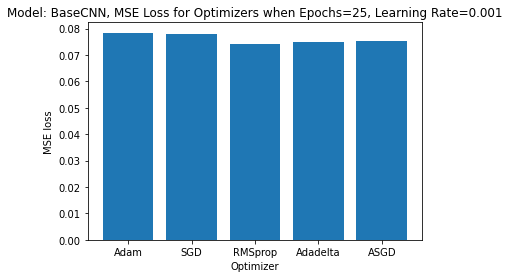

In [ ]:
plt.bar(dispatcher.keys(), mse_optimizers_BaseCNN)
plt.xlabel('Optimizer')
plt.ylabel('MSE loss')
plt.title('Model: BaseCNN, MSE Loss for Optimizers when Epochs=25, Learning Rate=0.001')
plt.show()

## Base CNN Model Architecture 2:

---


1. 1D CNN later with input = dimension of embedding, output = customisable, kernel size = 1, activation = Tanh()
2. 1D Maxpool Layer
3. 2 fully connected layers
4. 1 activation function for dense layers: ReLU()

This is a modification for the BaseCNN model above because the convolutional layer using Tanh activation instead of ReLU activation.
MSE loss is a little improved with this small change if epochs = 40.
In the previous model, lowest MSE corresponds to epochs = 25, 30.

In this model, MSE is lowest for 15 epochs.
Effect of learning rate remains similar i.e. 0.001.





In [ ]:
class BaseTanhCNN(nn.Module):
    def __init__(self, embedded_dimension, conv_out, window):
        super(BaseTanhCNN, self).__init__()
        self.vector_dim = embedded_dimension
        self.window = window
        self.out = conv_out
        self.activation = nn.ReLU()
        self.convolution = self.convolutional_layer()
        self.fc1 = nn.Linear(in_features=self.out, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=self.vector_dim)

    def convolutional_layer(self):
        return nn.Sequential(
            nn.Conv1d(in_channels=self.vector_dim, out_channels=self.out, kernel_size=self.window),
            nn.Tanh()
        )   

    def build_CNN(self, input_data):
        conv_output = self.convolution(input_data)
        kernel = conv_output.shape[2]
        maxpool = nn.MaxPool1d(kernel_size=kernel) 
        return maxpool(conv_output).squeeze()

    def forward(self, sent1, sent2):
        sent1 = torch.FloatTensor(sent1).to(device).unsqueeze(0)
        sent2 = torch.FloatTensor(sent2).to(device).unsqueeze(0)

        sent1 = self.build_CNN(sent1)
        sent1 = self.activation(self.fc1(sent1))
        sent1 = self.activation(self.fc2(sent1))

        sent2 = self.build_CNN(sent2)
        sent2 = self.activation(self.fc1(sent2))
        sent2 = self.activation(self.fc2(sent2))

        return sent1, sent2

In [ ]:
model = BaseTanhCNN(word_vec_dim, 64, 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
training_loss = []
validation_loss = []

for epoch in tqdm(range(1, EPOCHS + 1)):
    print("Epoch: ", epoch)
    train_loss = train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
print("Avg MSE Loss on Dev Data = ", np.mean(np.array(validation_loss)))

Epoch:  1
MSE of the method on the dev set: 0.0947064682841301
Epoch:  2
MSE of the method on the dev set: 0.08549576997756958
Epoch:  3
MSE of the method on the dev set: 0.08372917771339417
Epoch:  4
MSE of the method on the dev set: 0.08392795920372009
Epoch:  5
MSE of the method on the dev set: 0.07582604885101318
Epoch:  6
MSE of the method on the dev set: 0.07019131630659103
Epoch:  7
MSE of the method on the dev set: 0.07179336249828339
Epoch:  8
MSE of the method on the dev set: 0.07249576598405838
Epoch:  9
MSE of the method on the dev set: 0.07545516639947891
Epoch:  10
MSE of the method on the dev set: 0.07459237426519394
Epoch:  11
MSE of the method on the dev set: 0.07185330241918564
Epoch:  12
MSE of the method on the dev set: 0.0752953439950943
Epoch:  13
MSE of the method on the dev set: 0.07256466150283813
Epoch:  14
MSE of the method on the dev set: 0.07370348274707794
Epoch:  15
MSE of the method on the dev set: 0.0756872147321701
Epoch:  16
MSE of the method on the d

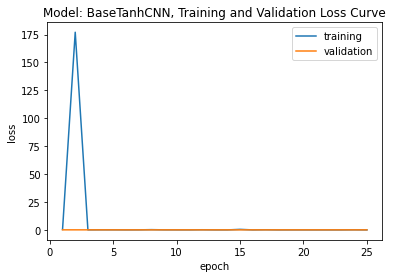

In [ ]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1,EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.title("Model: BaseTanhCNN, Training and Validation Loss Curve")
plt.show()

## Analyzing Effect of Epochs


In [ ]:
loss_criteria = nn.MSELoss()
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001

epoch_list = [15, 20, 25, 30, 40]
validation_mse = []
for epochs in tqdm(epoch_list):
    model = BaseTanhCNN(word_vec_dim, 64, 1)
    model.to(device) 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.zero_grad() 
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = train(model, train_data, optimizer)
        training_loss.append(train_loss)

    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


MSE of the method on the dev set: 0.07182443886995316



MSE of the method on the dev set: 0.07332584261894226



MSE of the method on the dev set: 0.07298237830400467



MSE of the method on the dev set: 0.07420618832111359



MSE of the method on the dev set: 0.07280556112527847



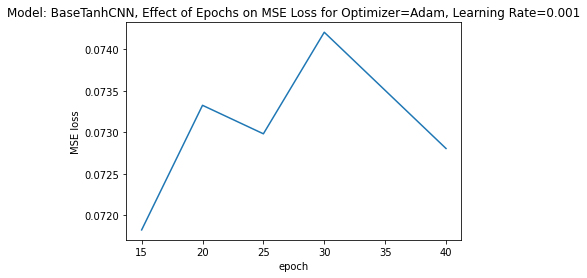

In [ ]:
plt.plot(epoch_list, validation_mse)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title("Model: BaseTanhCNN, Effect of Epochs on MSE Loss for Optimizer=Adam, Learning Rate=0.001")
plt.show()

## Analyzing Effect Learning Rate

In [ ]:
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
validation_mse = []

for lr in tqdm(learning_rates):
    model = BaseTanhCNN(word_vec_dim, 64, 1)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


MSE of the method on the dev set: 0.07587764412164688



MSE of the method on the dev set: 0.07629228383302689



MSE of the method on the dev set: 0.07683023065328598



MSE of the method on the dev set: 0.07693402469158173



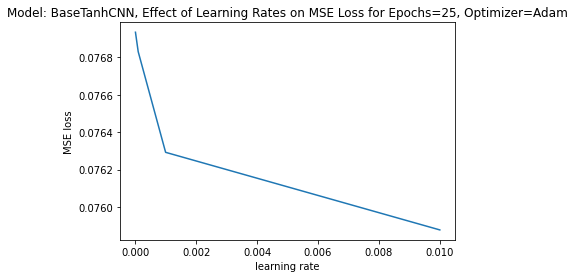

In [ ]:
plt.plot(learning_rates, validation_mse)
plt.xlabel('learning rate')
plt.ylabel('MSE loss')
plt.title('Model: BaseTanhCNN, Effect of Learning Rates on MSE Loss for Epochs=25, Optimizer=Adam')
plt.show()

## Experimenting with Different Optimizers

In [ ]:
EPOCHS = 15

In [ ]:
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
dispatcher = {  'Adam'      : torch.optim.Adam(model.parameters(), lr=learning_rate),
                'SGD'       : torch.optim.SGD(model.parameters(), lr=learning_rate),
                'RMSprop'   : torch.optim.RMSprop(model.parameters(), lr=learning_rate),
                'Adadelta'  : torch.optim.Adadelta(model.parameters(), lr=learning_rate),
                'ASGD'      : torch.optim.ASGD(model.parameters(), lr=learning_rate)
             }
mse_optimizers_BaseCNN = []
for opt in dispatcher.keys():
    model = BaseTanhCNN(word_vec_dim, out, 1)
    model.to(device)
    print(opt)
    optimizer = eval(opt, {'__builtins__':None}, dispatcher)
    optimizer.zero_grad()
    for epoch in tqdm(range(1, EPOCHS + 1)):
        train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    mse_optimizers_BaseCNN.append(test_loss)

Adam



MSE of the method on the dev set: 0.23434945940971375
SGD



MSE of the method on the dev set: 0.20009051263332367
RMSprop



MSE of the method on the dev set: 0.23504294455051422
Adadelta



MSE of the method on the dev set: 0.23138774931430817
ASGD



MSE of the method on the dev set: 0.22695551812648773


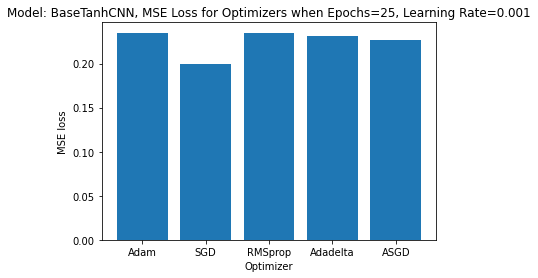

In [ ]:
plt.bar(dispatcher.keys(), mse_optimizers_BaseCNN)
plt.xlabel('Optimizer')
plt.ylabel('MSE loss')
plt.title('Model: BaseTanhCNN, MSE Loss for Optimizers when Epochs=25, Learning Rate=0.001')
plt.show()

## Complex Neural Network Architecture:
1. 2 1D Convolutional Layers with Tanh Activation
2. 1 1D Maxpool Layer
3. 2 fully connected layers
4. ReLU activation for the dense layers



> As complexity of the model increases, the loss does not reduce. Adding 2 convolutional layers keeps loss almost consistent around 0.07 - 0.08 at the cost of increased computational time. The time run a complex model for the same number of epochs is 8-12 minutes more expensive.

> Increasing the complexity by adding dropouts as regularization is a very bad idea. The loss increases to the range of 0.1 - 0.2. The loss is on the lower side if dropout rate is high. This is because the models are not overfitting the training data. So if dropout rates are higher, more percentage of nodes are switched off and that leads to a simpler model, hence lower loss. On the whole, complex models did not behave well.





In [ ]:
class CNN2Layer(nn.Module):
    def __init__(self, embedded_dimension, conv_out, window):
        super(CNN2Layer, self).__init__()
        self.vector_dim = embedded_dimension
        self.window = window
        self.out = conv_out
        self.activation = nn.ReLU()
        self.convolution1 = self.convolutional_layer1()
        self.convolution2 = self.convolutional_layer2()
        self.fc1 = nn.Linear(in_features=self.out[1], out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=self.vector_dim)

    def convolutional_layer1(self):
        return nn.Sequential(
            nn.Conv1d(in_channels=self.vector_dim, out_channels=self.out[0], kernel_size=self.window),
            nn.ReLU()
        )
    def convolutional_layer2(self):
        return nn.Sequential(
            nn.Conv1d(in_channels=self.out[0], out_channels=self.out[1], kernel_size=self.window),
            nn.ReLU()
        )   

    def build_CNN(self, input_data):
        conv_output1 = self.convolution1(input_data)
        conv_output2 = self.convolution2(conv_output1)
        kernel = conv_output2.shape[2]
        maxpool = nn.MaxPool1d(kernel_size=kernel) 
        return maxpool(conv_output2).squeeze()

    def forward(self, sent1, sent2):
        sent1 = torch.FloatTensor(sent1).to(device).unsqueeze(0)
        sent2 = torch.FloatTensor(sent2).to(device).unsqueeze(0)

        sent1 = self.build_CNN(sent1)
        sent1 = self.activation(self.fc1(sent1))
        sent1 = self.activation(self.fc2(sent1))
        sent2 = self.build_CNN(sent2)
        sent2 = self.activation(self.fc1(sent2))
        sent2 = self.activation(self.fc2(sent2))

        return sent1, sent2

In [ ]:
model = CNN2Layer(word_vec_dim, [32, 64], 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
training_loss = []
validation_loss = []

for epoch in tqdm(range(1, EPOCHS + 1)):
    print("Epoch: ", epoch)
    train_loss = train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

print("Avg MSE Loss on Dev Data= ", np.mean(np.array(validation_loss)))

Epoch:  1
MSE of the method on the dev set: 0.11250552535057068
Epoch:  2
MSE of the method on the dev set: 0.08787444978952408
Epoch:  3
MSE of the method on the dev set: 0.08770563453435898
Epoch:  4
MSE of the method on the dev set: 0.08171362429857254
Epoch:  5
MSE of the method on the dev set: 0.07989204674959183
Epoch:  6
MSE of the method on the dev set: 0.08169495314359665
Epoch:  7
MSE of the method on the dev set: 0.07770039886236191
Epoch:  8
MSE of the method on the dev set: 0.0781613141298294
Epoch:  9
MSE of the method on the dev set: 0.07765695452690125
Epoch:  10
MSE of the method on the dev set: 0.0760096088051796
Epoch:  11
MSE of the method on the dev set: 0.08045951277017593
Epoch:  12
MSE of the method on the dev set: 0.07713968306779861
Epoch:  13
MSE of the method on the dev set: 0.07778533548116684
Epoch:  14
MSE of the method on the dev set: 0.07375715672969818
Epoch:  15
MSE of the method on the dev set: 0.07651736587285995
Epoch:  16
MSE of the method on the 

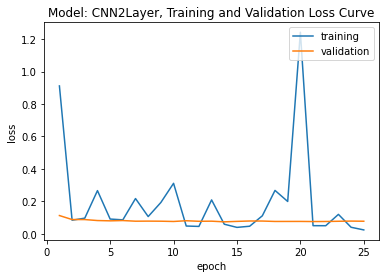

In [ ]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1,EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.title("Model: CNN2Layer, Training and Validation Loss Curve")
plt.show()

## CNN Model with Dropout Architecture:
1. 1 1D Convolutional Layer with ReLU Activation
2. 1 1D Maxpool Layer
3. 1 Fully Connected Layer with ReLU Activation
4. 1 Dropout Layer with customisable dropout rate
5. 1 Fully Connected Layer with Leaky ReLU 
6. 1 Fully Connected Layer with ReLU

In [ ]:
class DropoutCNN(nn.Module):
    def __init__(self, embedded_dimension, conv_out, window, dropout_rate, leak):
    super(DropoutCNN, self).__init__()
        self.vector_dim = embedded_dimension
        self.window = window
        self.out = conv_out
        self.activation1 = nn.ReLU()
        self.activation2 = nn.LeakyReLU(leak)
        self.convolution = self.convolutional_layer()
        self.drop = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(in_features=self.out, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=self.vector_dim)

    def convolutional_layer(self):
        return nn.Sequential(
            nn.Conv1d(in_channels=self.vector_dim, out_channels=self.out, kernel_size=self.window),
            nn.ReLU()
        )   

    def build_CNN(self, input_data):
        conv_output = self.convolution(input_data)
        kernel = conv_output.shape[2]
        maxpool = nn.MaxPool1d(kernel_size=kernel) 
        return maxpool(conv_output).squeeze()

    def forward(self, sent1, sent2):
        sent1 = torch.FloatTensor(sent1).to(device).unsqueeze(0)
        sent2 = torch.FloatTensor(sent2).to(device).unsqueeze(0)

        sent1 = self.build_CNN(sent1)
        sent1 = self.activation1(self.fc1(sent1))
        sent1 = self.drop(sent1)
        sent1 = self.activation2(self.fc2(sent1))
        sent1 = self.activation1(self.fc3(sent1))

        sent2 = self.build_CNN(sent2)
        sent2 = self.activation1(self.fc1(sent2))
        sent2 = self.drop(sent2)
        sent2 = self.activation2(self.fc2(sent2))
        sent2 = self.activation1(self.fc3(sent2))

        return sent1, sent2

In [ ]:

model = DropoutCNN(word_vec_dim, 32, 1, 0.5, 0.2)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
training_loss = []
validation_loss = []

for epoch in tqdm(range(1, EPOCHS + 1)):
    print("Epoch: ", epoch)
    train_loss = train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

print("Avg MSE Loss on Dev Data= ", np.mean(np.array(validation_loss)))

Epoch:  1
MSE of the method on the dev set: 0.1957201361656189
Epoch:  2
MSE of the method on the dev set: 0.16372479498386383
Epoch:  3
MSE of the method on the dev set: 0.1658247858285904
Epoch:  4
MSE of the method on the dev set: 0.15955135226249695
Epoch:  5
MSE of the method on the dev set: 0.1528930813074112
Epoch:  6
MSE of the method on the dev set: 0.15087276697158813
Epoch:  7
MSE of the method on the dev set: 0.14421416819095612
Epoch:  8
MSE of the method on the dev set: 0.13435406982898712
Epoch:  9
MSE of the method on the dev set: 0.13429322838783264
Epoch:  10
MSE of the method on the dev set: 0.14740179479122162
Epoch:  11
MSE of the method on the dev set: 0.1457592397928238
Epoch:  12
MSE of the method on the dev set: 0.13753259181976318
Epoch:  13
MSE of the method on the dev set: 0.13423407077789307
Epoch:  14
MSE of the method on the dev set: 0.12652802467346191
Epoch:  15
MSE of the method on the dev set: 0.12405785918235779
Epoch:  16
MSE of the method on the de

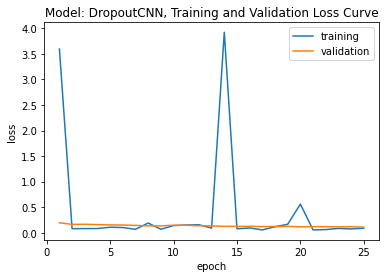

In [ ]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1,EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.title("Model: DropoutCNN, Training and Validation Loss Curve")
plt.show()

## Analyzing With Different Epochs

In [ ]:
model = DropoutCNN(word_vec_dim, 32, 1, 0.5, 0.2)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

epoch_list = [15, 20, 25, 30]
validation_mse = []
for epochs in tqdm(epoch_list):
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = train(model, train_data, optimizer)
        training_loss.append(train_loss)

    test_loss = test(model, dev_data)
    validation_mse.append(test_loss)


MSE of the method on the dev set: 0.11559964716434479



MSE of the method on the dev set: 0.1132168248295784



MSE of the method on the dev set: 0.10298991948366165



MSE of the method on the dev set: 0.0978817418217659



## Complex CNN Architecture 2

In [ ]:
class DropoutTanhCNN(nn.Module):
    def __init__(self, embedded_dimension, conv_out, window, dropout_rate):
        super(DropoutTanhCNN, self).__init__()
        self.vector_dim = embedded_dimension
        self.window = window
        self.out = conv_out
        self.activation = nn.ReLU()
        self.convolution = self.convolutional_layer()
        self.drop = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(in_features=self.out, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=self.vector_dim)

    def convolutional_layer(self):
        return nn.Sequential(
            nn.Conv1d(in_channels=self.vector_dim, out_channels=self.out, kernel_size=self.window),
            nn.Tanh()
        )   

    def build_CNN(self, input_data):
        conv_output = self.convolution(input_data)
        kernel = conv_output.shape[2]
        maxpool = nn.MaxPool1d(kernel_size=kernel) 
        return maxpool(conv_output).squeeze()

    def forward(self, sent1, sent2):
        sent1 = torch.FloatTensor(sent1).to(device).unsqueeze(0)
        sent2 = torch.FloatTensor(sent2).to(device).unsqueeze(0)

        sent1 = self.build_CNN(sent1)
        sent1 = self.activation(self.fc1(sent1))
        sent1 = self.drop(sent1)
        sent1 = self.activation(self.fc2(sent1))

        sent2 = self.build_CNN(sent2)
        sent2 = self.activation(self.fc1(sent2))
        sent2 = self.drop(sent2)
        sent2 = self.activation(self.fc2(sent2))

        return sent1, sent2

In [ ]:
model = DropoutTanhCNN(word_vec_dim, 64, 1, 0.5)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
training_loss = []
validation_loss = []

for epoch in tqdm(range(1, EPOCHS + 1)):
    print("Epoch: ", epoch)
    train_loss = train(model, train_data, optimizer)
    test_loss = test(model, dev_data)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

print("Avg MSE Loss on Dev Data= ", np.mean(np.array(validation_loss)))

Epoch:  1
MSE of the method on the dev set: 0.2039584517478943
Epoch:  2
MSE of the method on the dev set: 0.18345792591571808
Epoch:  3
MSE of the method on the dev set: 0.17495737969875336
Epoch:  4
MSE of the method on the dev set: 0.1653161346912384
Epoch:  5
MSE of the method on the dev set: 0.14464810490608215
Epoch:  6
MSE of the method on the dev set: 0.1428995281457901
Epoch:  7
MSE of the method on the dev set: 0.13700179755687714
Epoch:  8
MSE of the method on the dev set: 0.1357501745223999
Epoch:  9
MSE of the method on the dev set: 0.12131992727518082
Epoch:  10
MSE of the method on the dev set: 0.11866827309131622
Epoch:  11
MSE of the method on the dev set: 0.10647699981927872
Epoch:  12
MSE of the method on the dev set: 0.10328008979558945
Epoch:  13
MSE of the method on the dev set: 0.10388527065515518
Epoch:  14
MSE of the method on the dev set: 0.11001422256231308
Epoch:  15
MSE of the method on the dev set: 0.10408967733383179
Epoch:  16
MSE of the method on the de

This model requires more amount of regularization because the model overfits the training data throughout the epochs, except few peaks.

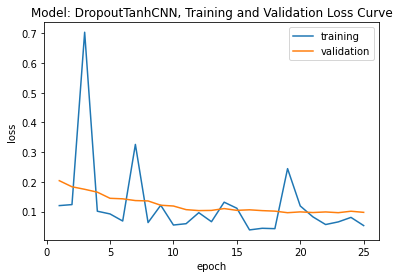

In [ ]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1,EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.title("Model: DropoutTanhCNN, Training and Validation Loss Curve")
plt.show()

### Activation Functions:
Analysizing with different combinations of activation functions shows:
1. it's not a good idea to use different activations on the different layers
2. ReLU activation works better than LeakyReLU - because deciding the negative slope parameter of the LeakyReLU is tricky and the parameter value changes the loss
3. ReLU function consistently gives much better results than Tanh as well
4. Using ReLU() on all the layers and keeping the model simple is the best option

## Applying Batch Processing

Batch Processing does not work well and increases the MSE loss. Perhaps because we are diluting the training  data by concatenating the inputs in bathc sizes of 10-20. But this greatly improves the time, the time taken is about 50% less.

Applying batch processing does not train the model. There is no variation in the training and test losses. For every batch the model gives the same loss.

In [ ]:
def word_vecs_by_batch(word_vectors, sent_words, largest_len):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    for i in range(largest_len-len(sent_words)):
        vecs.append([0.]*word_vec_dim)
    return np.array(np.transpose(vecs))

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv =  word_vecs_by_batch(word_vectors, ts, largest_len)
        text_vecs.append(vv)
    return np.array(text_vecs)

In [ ]:
def batch_train(model, data, optimizer, batch_size):
    model.train()
    train_loss = 0
    for i in range(0,len(data),batch_size):

        s1_embeddings = build_mini_batch(data['Sent1'][i:i+batch_size], word_vectors)
        s1_embeddings = s1_embeddings.reshape((s1_embeddings.shape[1], s1_embeddings.shape[0]*s1_embeddings.shape[2]))
        if s1_embeddings.shape[0] == 0: continue 
        s2_embeddings = build_mini_batch(data['Sent2'][i:i+batch_size], word_vectors)
        s2_embeddings = s2_embeddings.reshape((s2_embeddings.shape[1], s2_embeddings.shape[0]*s2_embeddings.shape[2]))
        if s2_embeddings.shape[0] == 0: continue

        target = torch.mean(torch.FloatTensor(list(data['SimScore'][i:i+batch_size])), dim=0).to(device)
        target = torch.reshape(target,(-1,))
        optimizer.zero_grad()
        s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

        x=s1_vector.reshape(1,-1)
        y=s2_vector.reshape(1,-1)
        prediction = cos(x, y)
        loss = loss_criteria(prediction, target)
        train_loss += loss.detach()
        loss.backward()
        optimizer.step()

    avg_loss = train_loss/(i+1)
    return avg_loss

def batch_test(model, data, batch_size, LR_scheduling=False):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        batch = 0
        for i in range(0,len(data),batch_size):
            batch += 1
            s1_embeddings = build_mini_batch(data['Sent1'][i:i+batch_size], word_vectors)
            s1_embeddings = s1_embeddings.reshape((s1_embeddings.shape[1], s1_embeddings.shape[0]*s1_embeddings.shape[2]))
            if s1_embeddings.shape[0] == 0: continue 
            s2_embeddings = build_mini_batch(data['Sent2'][i:i+batch_size], word_vectors)
            s2_embeddings = s2_embeddings.reshape((s2_embeddings.shape[1], s2_embeddings.shape[0]*s2_embeddings.shape[2]))
            if s2_embeddings.shape[0] == 0: continue

            truth = torch.mean(torch.FloatTensor(list(data['SimScore'][i:i+batch_size])), dim=0).to(device)
            truth = torch.reshape(truth,(-1,))

            s1_vector, s2_vector = model(s1_embeddings, s2_embeddings)

            x=s1_vector.reshape(1,-1)
            y=s2_vector.reshape(1,-1)
            prediction = cos(x, y)
            test_loss += loss_criteria(prediction, truth)

            if LR_scheduling: scheduler.step()

    avg_loss = test_loss/batch
    print('Loss of the method on the dev set:', avg_loss.item())
    
    return avg_loss.item()

In [ ]:
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
model = BaseTanhCNN(word_vec_dim, 64, 1)
model.to(device)
validation_mse = []
training_loss = []
validation_loss = []

batch_size = 10
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_loss = batch_train(model, train_data, optimizer, batch_size)
    training_loss.append(train_loss)
    test_loss = batch_test(model, dev_data, batch_size)
    validation_loss.append(test_loss)
print('Avg validation loss = ', np.mean(np.array(validation_loss)))

Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the dev set: 0.2428339421749115
Loss of the method on the de

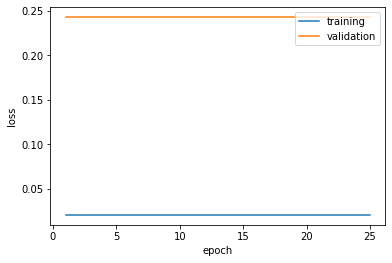

In [25]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1, EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Batch Processing with Learning Rate Scheduling
Learning Rate scheduling did not have a major impact. Learning rate around 0.001 - 0.0001 have consistently given good performance. Tweaking the learning rate via scheduling slightly reduced MSE loss to 0.23 from 0.24 loss observed with only batch scheduling.

In [26]:
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)
optimizer.zero_grad()
model = BaseTanhCNN(word_vec_dim, 64, 1)
model.to(device)
validation_mse = []
training_loss = []
validation_loss = []

batch_size = 10
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_loss = batch_train(model, train_data, optimizer, batch_size)
    training_loss.append(train_loss)
    test_loss = batch_test(model, dev_data, batch_size, True)
    validation_loss.append(test_loss)
print('Avg validation loss = ', np.mean(np.array(validation_loss)))


Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of the method on the dev set: 0.23678846657276154
Loss of th

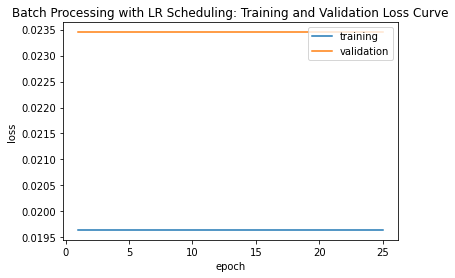

In [ ]:
plt.plot(range(1,EPOCHS+1), training_loss)
plt.plot(range(1, EPOCHS+1), validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.title("Batch Processing with LR Scheduling: Training and Validation Loss Curve")
plt.show()

In [ ]:
model = BaseCNN(word_vec_dim, 64, 1)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
training_loss = []
batch_size = 10
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_loss = batch_train(model, train_data, optimizer, batch_size)
    training_loss.append(train_loss)
batch_test(model, dev_data, batch_size)


Loss of the method on the dev set: 0.2812969982624054


0.2812969982624054

In [ ]:
model = DropoutCNN(word_vec_dim, 32, 1, 0.5, 10)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
validation_mse = []
training_loss = []

batch_size = 10
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_loss = batch_train(model, train_data, optimizer, batch_size)
    training_loss.append(train_loss)
test_loss = batch_test(model, dev_data, batch_size)


Loss of the method on the dev set: 0.21509911119937897


In [ ]:
model = DropoutTanhCNN(word_vec_dim, 32, 1, 0.5)
model.to(device)
cos = nn.CosineSimilarity()
loss_criteria = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
validation_mse = []
training_loss = []

batch_size = 10
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_loss = batch_train(model, train_data, optimizer, batch_size)
    training_loss.append(train_loss)
test_loss = batch_test(model, dev_data, batch_size)


Loss of the method on the dev set: 0.024276429787278175


### Final Model
Simple architecture with 1 convolutional network followed by 2 fully connected layers all having ReLU activation.

In [ ]:
import pickle

info_to_save = {
    'model_state_dict': model.state_dict(),
    'conv_out': 64,
    'window': 1, 
    'oov_vec': oov_vec
}

with open('CNN_Classifier.state_dict', 'wb') as ff:
    pickle.dump(info_to_save, ff)